In [285]:
import random as rnd
from itertools import combinations

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from tqdm import tqdm

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.misc_utils as misc_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.common.utils.plot_utils as plot_utils
import matching.misc.cpg_const as cpg_const
from matching.glema.common.model import InferenceGNN

In [286]:
args = arg_utils.parse_args( use_default=True )

args.dataset = "CPG_augm_large"
args.directed = False
args.anchored = True
version = model_utils.get_latest_model_version( args )
model_name = model_utils.get_model_name( args, version )

args = arg_utils.load_args( args, model_name )
args.iso = True
args.test_data = True

In [287]:
model = InferenceGNN( args )

Loading model from /Users/jeanjour/Documents/projects/python/dpd-subgraph-matching/matching/glema/training/save/CPG_augm_large_undirected_anchored_v1/model.pt ...


In [288]:
def predict( model, G_source, G_query ) -> float:
    p, (x, y) = model.predict( G_source, G_query )
    return p


def is_subgraph( model: InferenceGNN, G_source, G_query, conf=0.5 ) -> bool:
    p, (x, y) = model.predict( G_source, G_query, conf=conf )
    print( f"query is subgraph of source: {x == 1.0} [{p:.3}]" )
    return x == 1.0

In [289]:
record_scopes = graph_utils.get_record_scopes( args )
design_patterns = graph_utils.get_design_patterns( args )
label_args = {
    "record_scopes": record_scopes,
    "design_patterns": design_patterns
}

In [290]:
source_graphs = graph_utils.load_source_graphs( args )
pattern_graphs = graph_utils.get_pattern_graphs( args, source_graphs, include_w_o_pattern=True )
pattern_counts = { dp: len( l ) for dp, l in pattern_graphs.items() }
pattern_counts

{'OBSERVER': 83,
 'FACTORY_METHOD': 49,
 'BUILDER': 25,
 'ADAPTER': 13,
 'SINGLETON': 5,
 'FACADE': 7,
 'ABSTRACT_FACTORY': 16,
 'N/D': 1022}

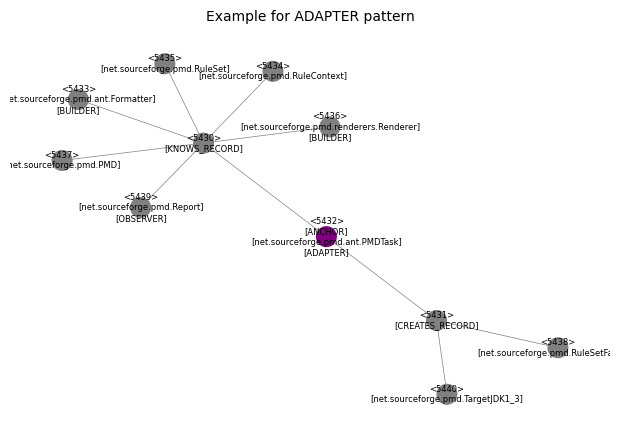

In [291]:
dp_target = cpg_const.DesignPatternType.ADAPTER.value
dp_target_graph = pattern_graphs[ dp_target ][ 2 ]

plot_utils.plot_graph( dp_target_graph,
                       title=f"Example for {dp_target} pattern",
                       nodeColors=graph_utils.get_node_colors( dp_target_graph ),
                       nodeLabels=graph_utils.get_node_labels( dp_target_graph, **label_args ) )

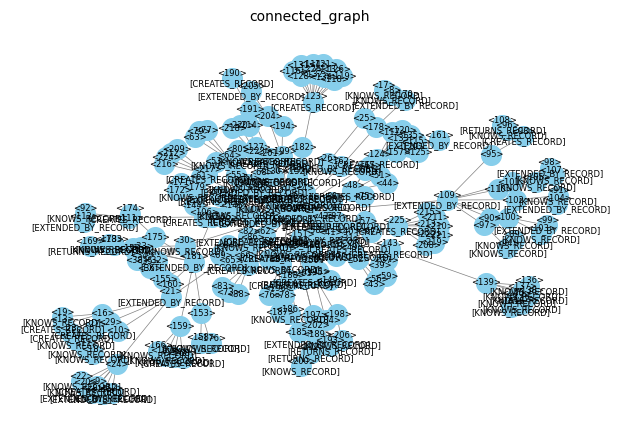

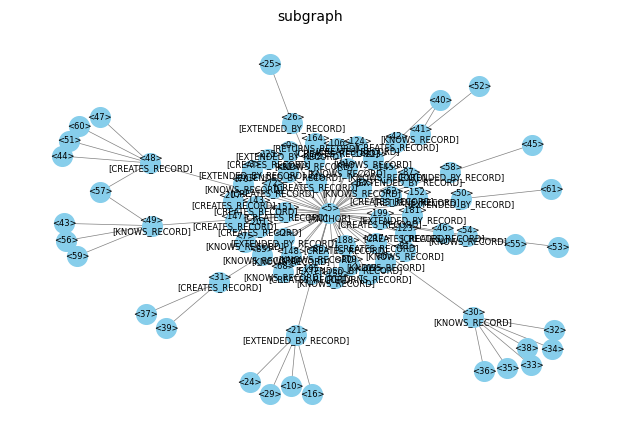

In [292]:
def connect_graphs_at_anchor( graphs, keep_radius=-1 ):
    G = nx.Graph()
    if len( graphs ) == 0:
        return G

    anchor = None
    for G_source in graphs:
        source_anchor = graph_utils.get_anchor( G_source )
        if keep_radius > 0:
            G_source = graph_utils.subgraph( G_source, source_anchor, keep_radius )
        mapping = { }
        for nid, ndata in G_source.nodes( data=True ):
            new_nid = G.number_of_nodes()
            if nid == source_anchor:
                if anchor is not None:
                    mapping[ nid ] = anchor
                    continue
                anchor = new_nid
            G.add_node( G.number_of_nodes(), **ndata )
            mapping[ nid ] = new_nid
        for source_nid, target_nid, edata in G_source.edges( data=True ):
            G.add_edge( mapping[ source_nid ], mapping[ target_nid ], **edata )

    if not nx.is_connected( G ):
        raise AssertionError( f"Graphs couldn't be connected at anchor!" )

    return G


connected_graph = connect_graphs_at_anchor( pattern_graphs[ dp_target ], keep_radius=3 )
plot_utils.plot_graph( connected_graph, title="connected_graph",
                       nodeLabels=graph_utils.get_node_labels( connected_graph ) )


def subgraph_from_anchor_of_size( G, max_n ):
    anchor = graph_utils.get_anchor( G )
    bfs = nx.bfs_tree( G, source=anchor )
    subset = list( bfs.nodes )[ :max_n ]
    return G.subgraph( subset ).copy()


subgraph = subgraph_from_anchor_of_size( connected_graph, max_n=80 )
plot_utils.plot_graph( subgraph, title="subgraph",
                       nodeLabels=graph_utils.get_node_labels( subgraph ) )

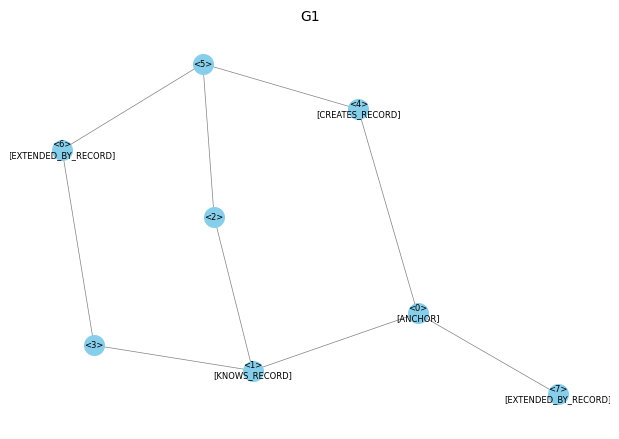

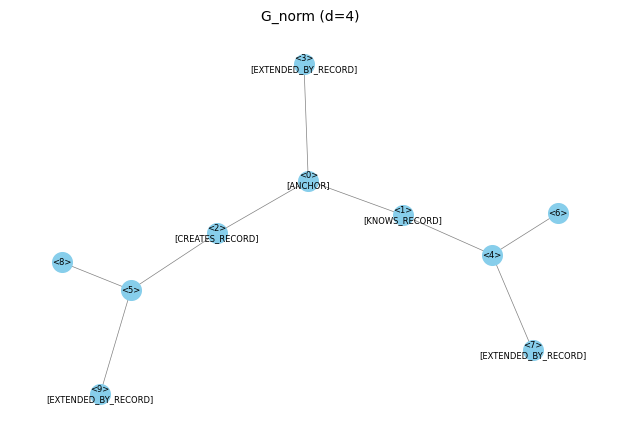

In [293]:
def normalize_graph( G, max_distance=4 ):
    G_norm = nx.Graph()
    anchor = graph_utils.get_anchor( G )
    paths = { }
    stack = [ (anchor, ("", [ ]), None, None) ]
    furthest_distance = 0
    while len( stack ) > 0:

        current_node, (label_path, node_path), parent, parent_source = stack.pop( 0 )
        if (current_node == anchor and parent is not None) or len( label_path ) >= max_distance:
            continue

        current_node_norm = G_norm.number_of_nodes()
        label_path += str( G.nodes[ current_node ][ "label" ] )
        if label_path not in paths.keys():
            paths[ label_path ] = [ *node_path, current_node_norm ]
            n_data: dict = G.nodes[ current_node ]
            n_data.pop( "presence", None )
            G_norm.add_node( current_node_norm, presence=0, **n_data )
            if parent is not None:
                G_norm.add_edge( parent, current_node_norm )
        else:
            current_node_norm = paths[ label_path ][ -1 ]

        node_path = paths[ label_path ]
        for n in node_path:
            G_norm.nodes[ n ][ "presence" ] += 1

        if len( label_path ) > furthest_distance:
            furthest_distance = len( label_path )

        for child in G.neighbors( current_node ):
            if child == parent_source:
                continue
            stack.append( (child, (label_path, node_path), current_node_norm, current_node) )

    return G_norm, furthest_distance


def addCpgNode( G, label: cpg_const.NodeLabel, anchor=False ):
    node_id = G.number_of_nodes()
    anchor_idx = 1 if anchor else 0
    G.add_node( node_id, label=misc_utils.get_enum_idx( label ), anchor=anchor_idx )
    return node_id


# Example usage
G1 = nx.Graph()
n11 = addCpgNode( G1, cpg_const.NodeLabel.RECORD, anchor=True )
n12 = addCpgNode( G1, cpg_const.NodeLabel.KNOWS_RECORD )
n13 = addCpgNode( G1, cpg_const.NodeLabel.RECORD )
n14 = addCpgNode( G1, cpg_const.NodeLabel.RECORD )
n15 = addCpgNode( G1, cpg_const.NodeLabel.CREATES_RECORD )
n16 = addCpgNode( G1, cpg_const.NodeLabel.RECORD )
n17 = addCpgNode( G1, cpg_const.NodeLabel.EXTENDED_BY_RECORD )
n18 = addCpgNode( G1, cpg_const.NodeLabel.EXTENDED_BY_RECORD )
G1.add_edge( n11, n12 )
G1.add_edge( n12, n13 )
G1.add_edge( n12, n14 )
G1.add_edge( n11, n15 )
G1.add_edge( n15, n16 )
G1.add_edge( n13, n16 )
G1.add_edge( n14, n17 )
G1.add_edge( n16, n17 )
G1.add_edge( n11, n18 )
plot_utils.plot_graph( G1, title="G1", nodeLabels=graph_utils.get_node_labels( G1 ) )

G_norm, d = normalize_graph( G1 )
plot_utils.plot_graph( G_norm, title=f"G_norm (d={d})", nodeLabels=graph_utils.get_node_labels( G_norm ) )

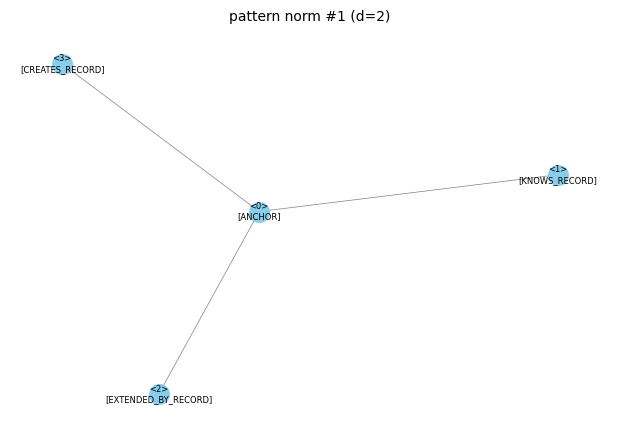

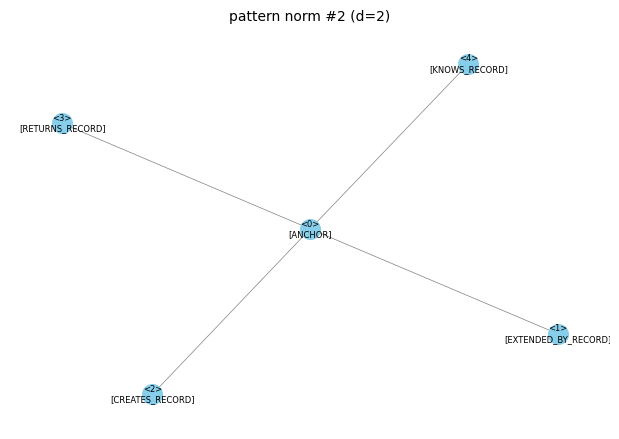

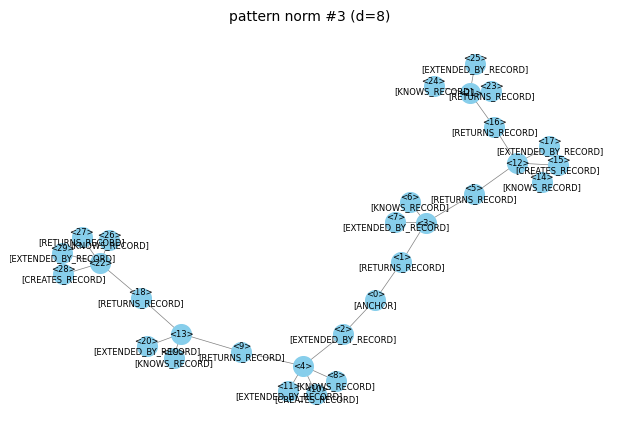

In [294]:
for idx, pattern in enumerate( pattern_graphs[ cpg_const.DesignPatternType.FACTORY_METHOD.value ][ :3 ] ):
    pattern_norm, d = normalize_graph( pattern, max_distance=8 )
    plot_utils.plot_graph( pattern_norm, title=f"pattern norm #{idx + 1} (d={d})",
                           nodeLabels=graph_utils.get_node_labels( pattern_norm ) )

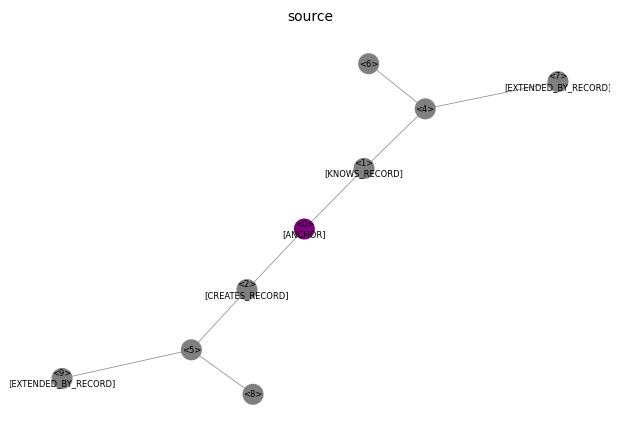

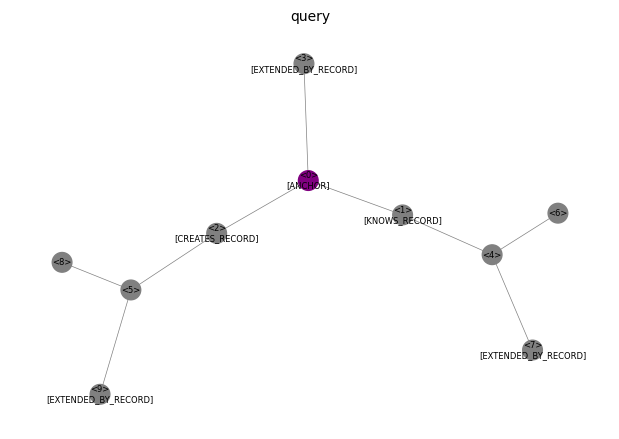

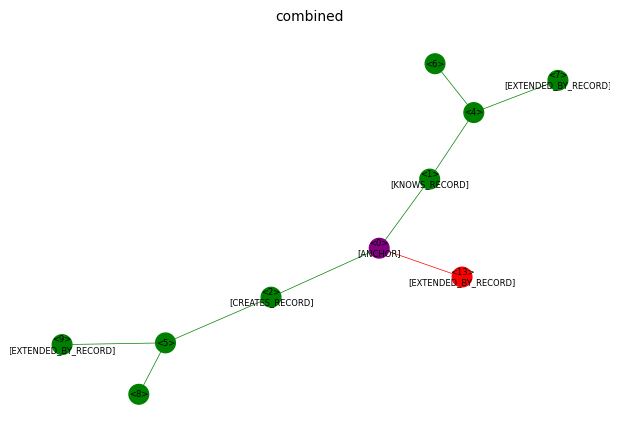

In [295]:
def get_all_norm_paths( graph ):
    paths = [ ]
    root = graph_utils.get_anchor( graph )
    dfs_tree = nx.dfs_tree( graph, root )

    def dfs( node, path_ids, path_labels ):
        path_ids.append( node )
        path_labels.append( str( graph.nodes[ node ][ 'label' ] ) )
        children = list( dfs_tree.successors( node ) )
        if not children:
            paths.append( (list( path_ids ), "".join( path_labels )) )
        else:
            for child in children:
                dfs( child, path_ids, path_labels )
        path_ids.pop()
        path_labels.pop()

    dfs( root, [ ], [ ] )
    return paths


def combine_normalized( source: nx.Graph, query: nx.Graph, matching_colors: dict[ int, str ] = None ):
    source = source.copy()
    query = query.copy()

    def find_longest_overlap( query_label, source_labels ):
        for length in range( len( query_label ), 0, -1 ):
            prefix = query_label[ :length ]
            for source_label, source_ids in source_labels.items():
                if source_label.startswith( prefix ):
                    return prefix, source_ids[ :length ]
        return None, None

    source_paths = get_all_norm_paths( source )
    query_paths = get_all_norm_paths( query )
    source_labels = { labels: ids for ids, labels in source_paths }
    source_node_count = len( source.nodes )
    mapping = { }
    for query_ids, query_label in query_paths:
        matched_prefix, matched_ids = find_longest_overlap( query_label, source_labels )
        if matched_prefix:
            for qid, sid in zip( query_ids[ :len( matched_prefix ) ], matched_ids ):
                mapping[ qid ] = sid
            # If there are unmatched query nodes, assign new IDs
            for qid in query_ids[ len( matched_prefix ): ]:
                mapping[ qid ] = qid + source_node_count + 1
        else:
            # If no match at all, assign new IDs
            for qid in query_ids:
                mapping[ qid ] = qid + source_node_count + 1

    query = nx.relabel_nodes( query, mapping )
    return graph_utils.combine_graph( source, query, graph_utils.get_anchor( source ), matching_colors=matching_colors )


G_source = G_norm.copy()
G_query = G_norm.copy()
G_source.remove_node( 3 )
plot_utils.plot_graph( G_source, title="source",
                       nodeLabels=graph_utils.get_node_labels( G_source ),
                       nodeColors=graph_utils.get_node_colors( G_source ) )
plot_utils.plot_graph( G_query, title="query",
                       nodeLabels=graph_utils.get_node_labels( G_query ),
                       nodeColors=graph_utils.get_node_colors( G_query ) )

matching_colors = {
    2: "purple",
    1: "green",
    0: "grey",
    -1: "red"
}
combined_graph, node_colors, edge_colors = combine_normalized( G_source, G_query, matching_colors=matching_colors )
plot_utils.plot_graph( combined_graph, title="combined",
                       nodeLabels=graph_utils.get_node_labels( combined_graph ),
                       nodeColors=node_colors, edgeColors=edge_colors )

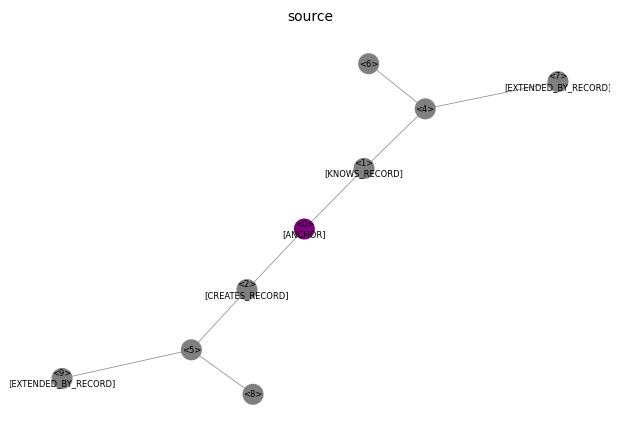

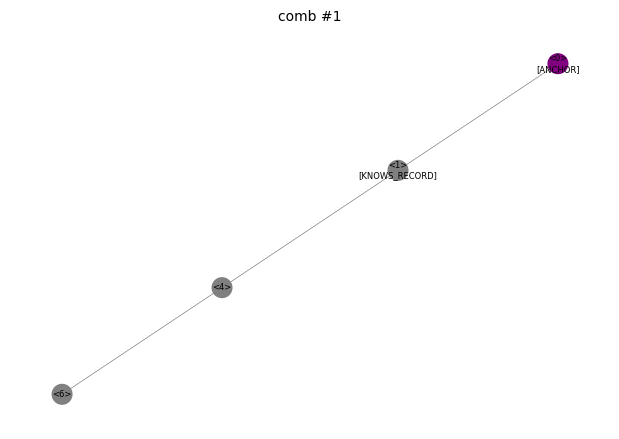

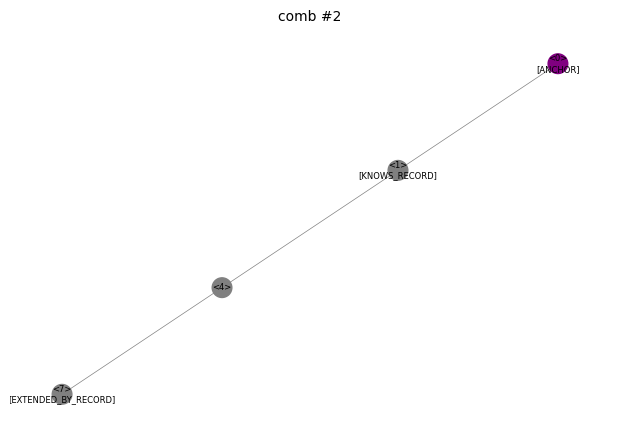

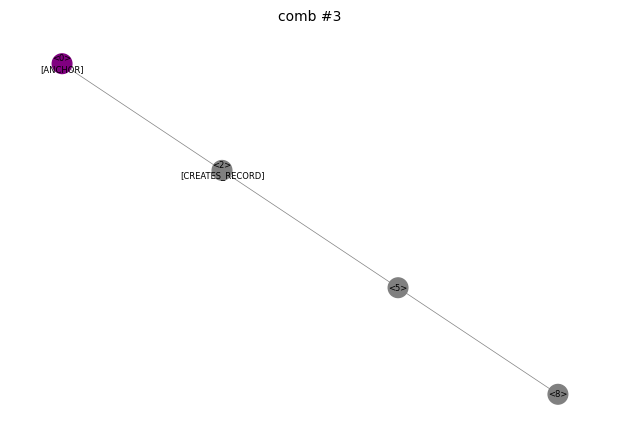

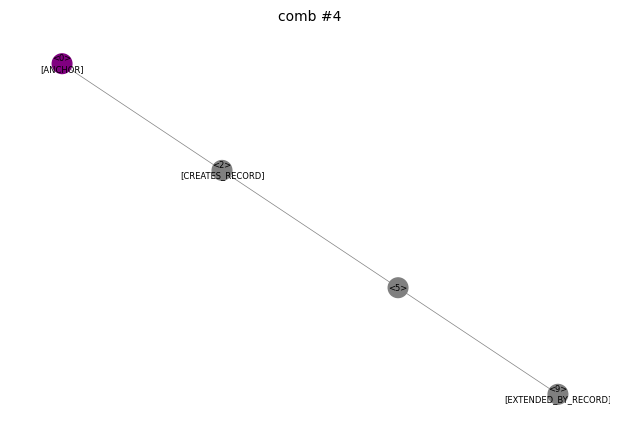

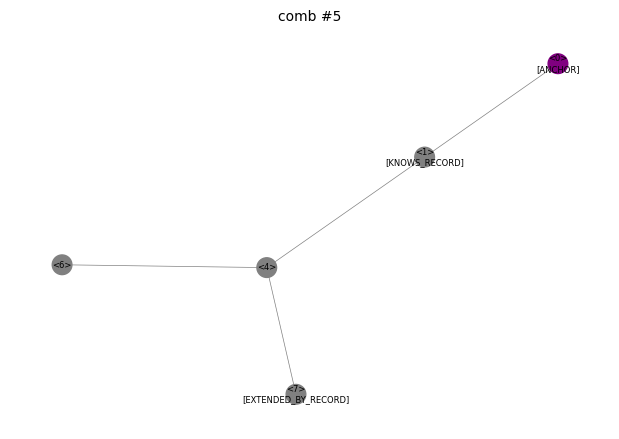

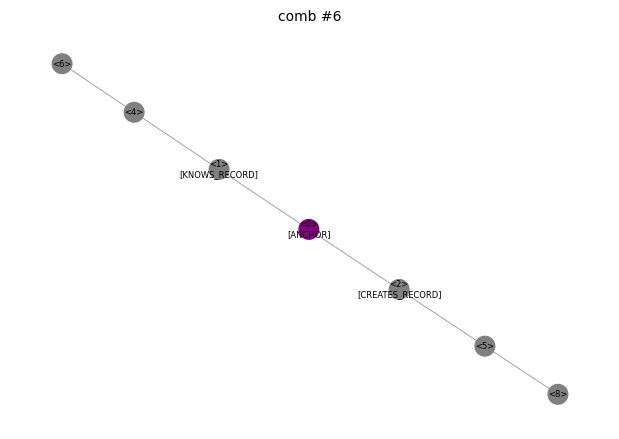

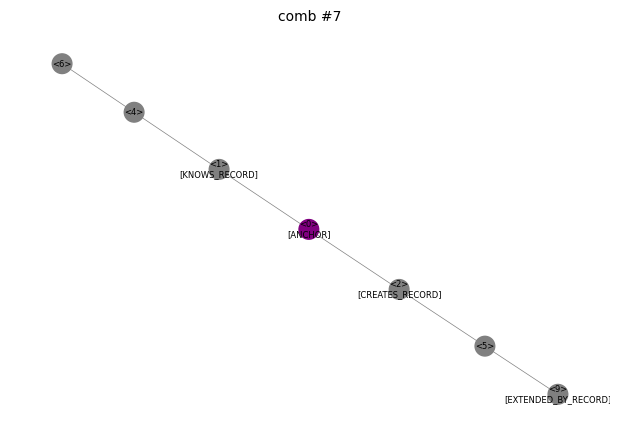

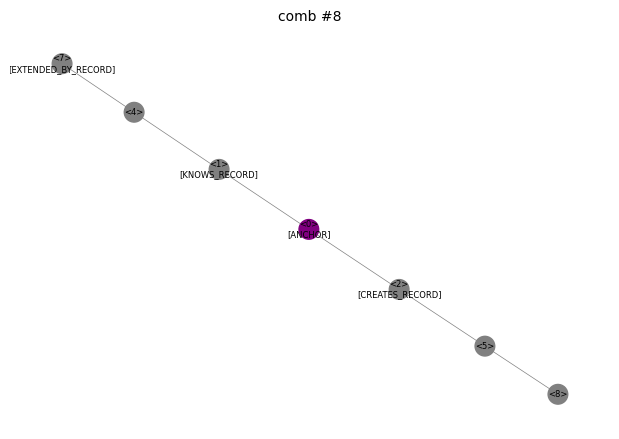

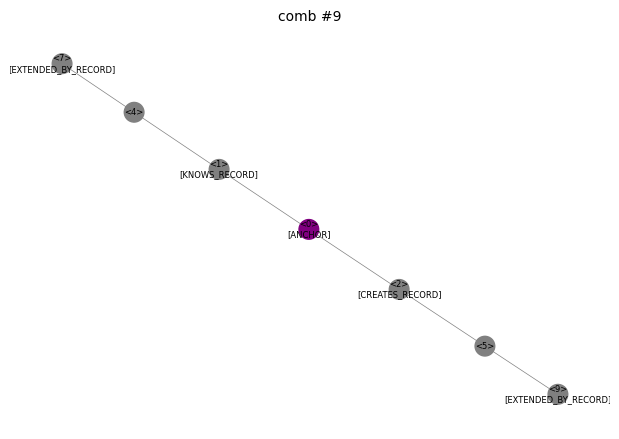

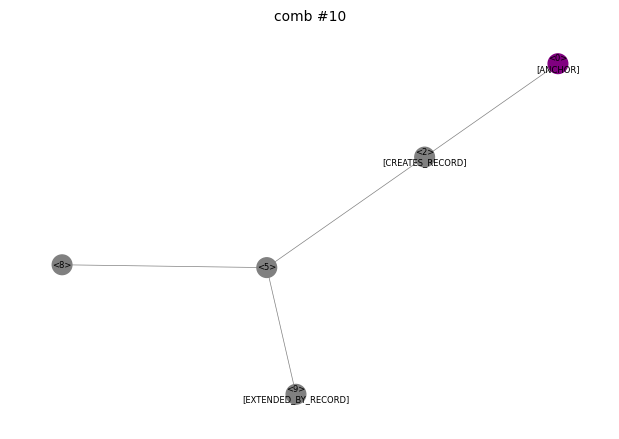

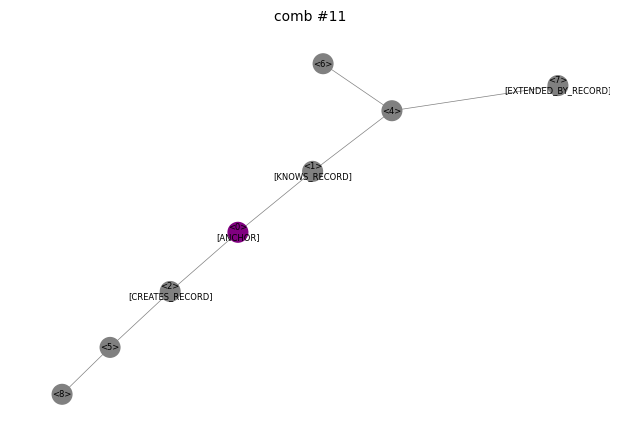

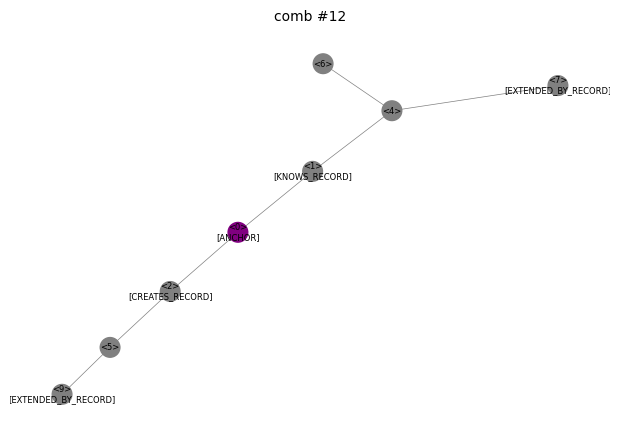

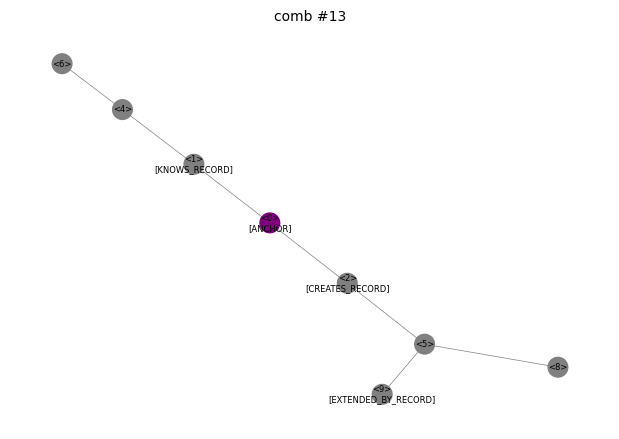

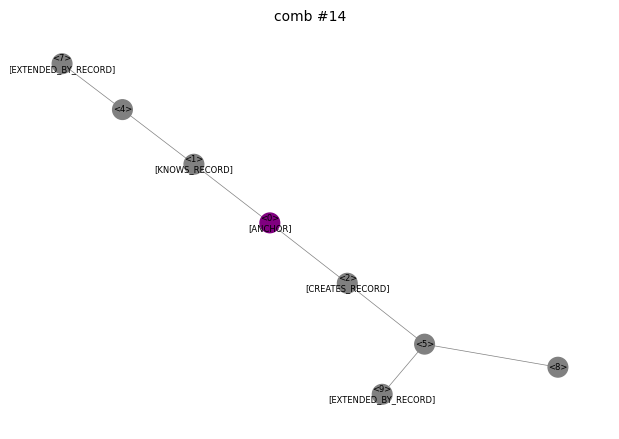

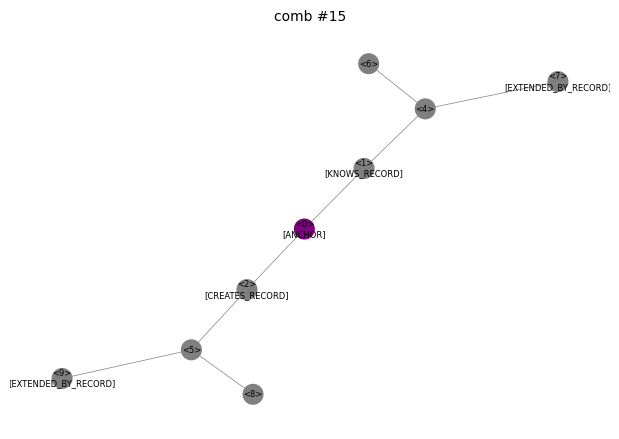

In [296]:
def gen_normalized_path_combinations( G, max_d=-1, n_min=-1, n_max=-1 ):
    paths = get_all_norm_paths( G )
    if max_d > 0:
        paths = [ (np[ :max_d + 1 ], lp[ :max_d + 1 ]) for np, lp in paths ]
        path_distinct = { lp: np for np, lp in paths }
        paths = [ (path_distinct[ lp ], lp) for lp in path_distinct.keys() ]

    if n_max < 0:
        n_max = len( paths )
    path_combinations = [ ]
    for size in range( max( n_min, 1 ), n_max + 1 ):
        path_combinations.extend( combinations( paths, size ) )
    combination_graphs = [ ]
    for path_combination in path_combinations:
        node_subset = [ ]
        for n_path, _ in path_combination:
            node_subset.extend( [ *n_path ] )
        combination_graphs.append( G.subgraph( set( node_subset ) ) )
    return combination_graphs


plot_utils.plot_graph( G_source, title="source",
                       nodeLabels=graph_utils.get_node_labels( G_source ),
                       nodeColors=graph_utils.get_node_colors( G_source ) )
for idx, graph in enumerate( gen_normalized_path_combinations( G_source, max_d=-1 ) ):
    plot_utils.plot_graph( graph, title=f"comb #{idx + 1}",
                           nodeLabels=graph_utils.get_node_labels( graph ),
                           nodeColors=graph_utils.get_node_colors( graph ) )

100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


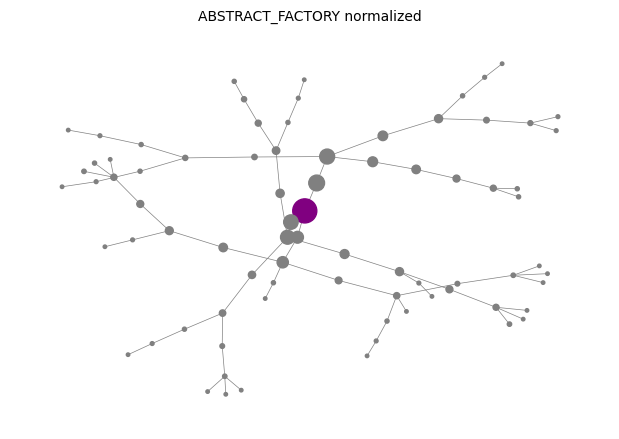

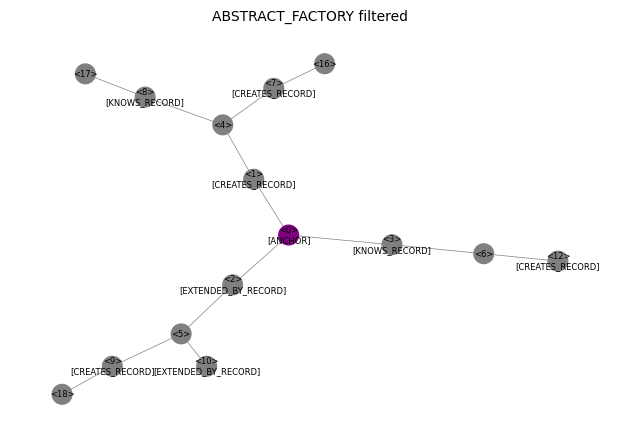

num nodes: 238
num nodes norm: 79
max presence: 238
min presence: 1
mean presence: 15.670886075949367
median presence: 3.0
q[0.83] presence: 23.0


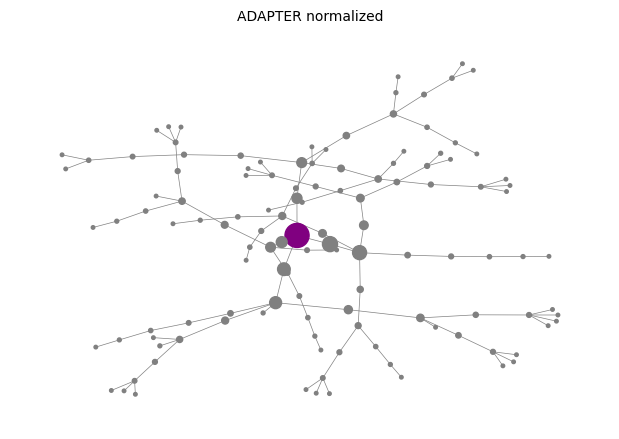

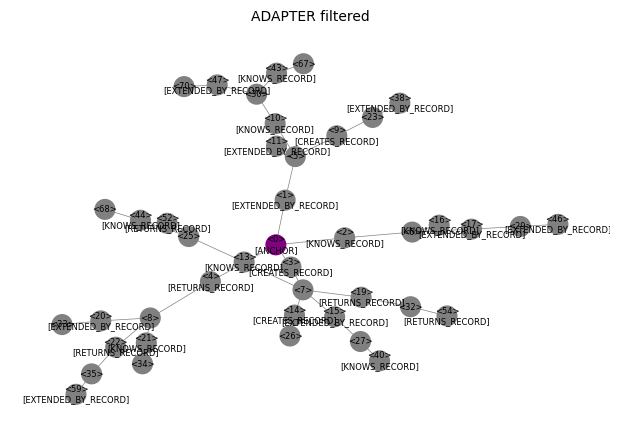

num nodes: 205
num nodes norm: 123
max presence: 205
min presence: 1
mean presence: 8.560975609756097
median presence: 3.0
q[0.7] presence: 5.0


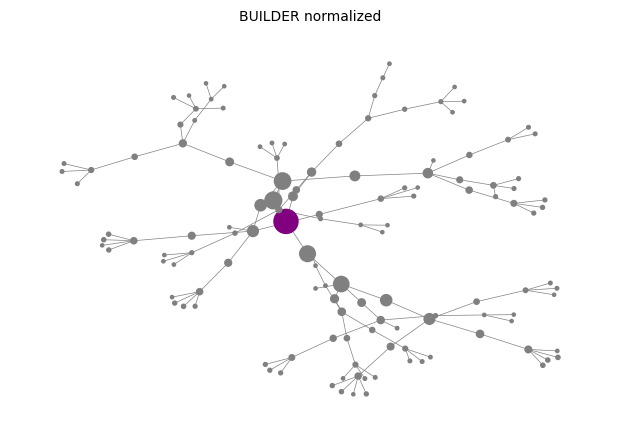

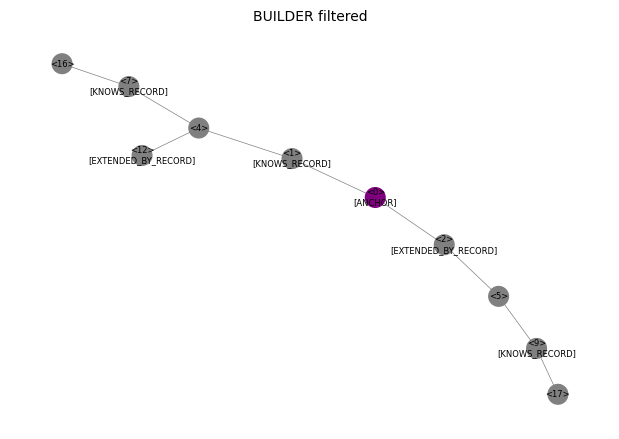

num nodes: 969
num nodes norm: 133
max presence: 969
min presence: 1
mean presence: 45.045112781954884
median presence: 10.0
q[0.93] presence: 135.12000000000006


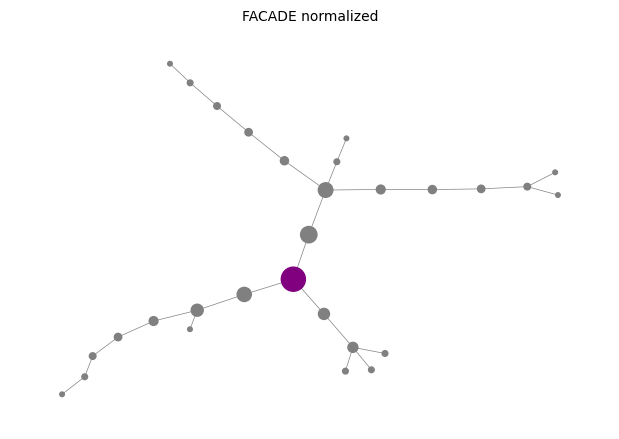

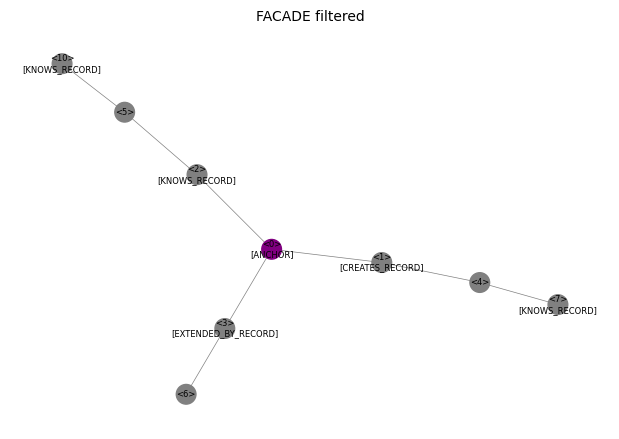

num nodes: 51
num nodes norm: 29
max presence: 51
min presence: 1
mean presence: 6.896551724137931
median presence: 3.0
q[0.72] presence: 6.0


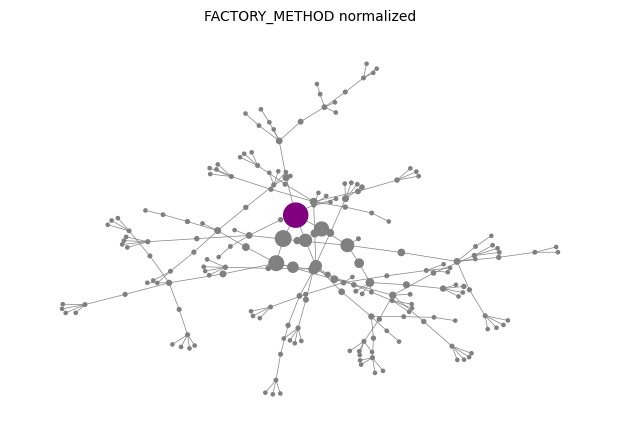

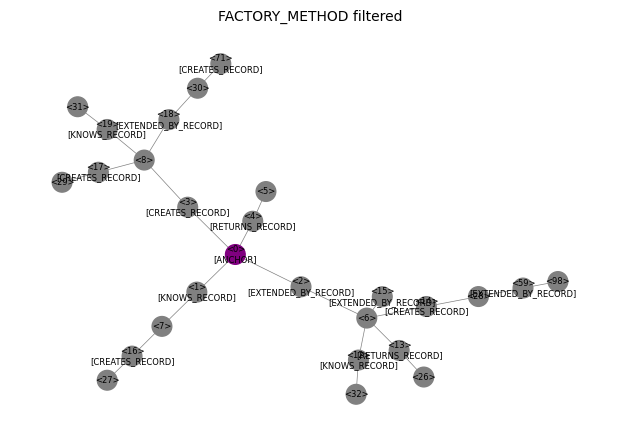

num nodes: 772
num nodes norm: 204
max presence: 772
min presence: 1
mean presence: 18.235294117647058
median presence: 2.0
q[0.87] presence: 25.609999999999985


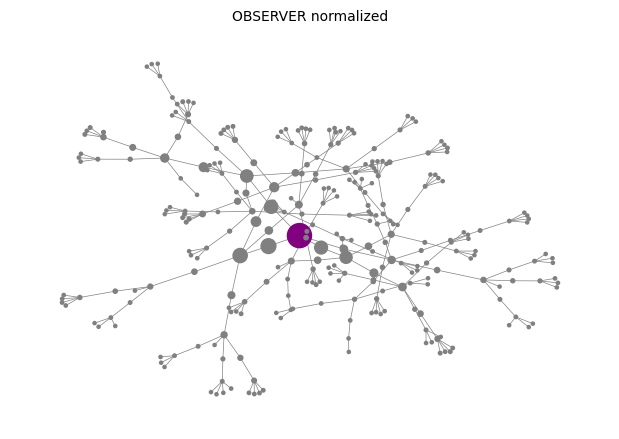

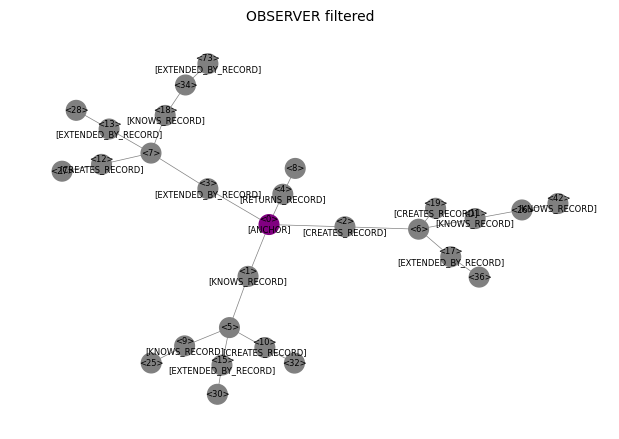

num nodes: 1641
num nodes norm: 294
max presence: 1641
min presence: 1
mean presence: 30.874149659863946
median presence: 5.0
q[0.91] presence: 63.0


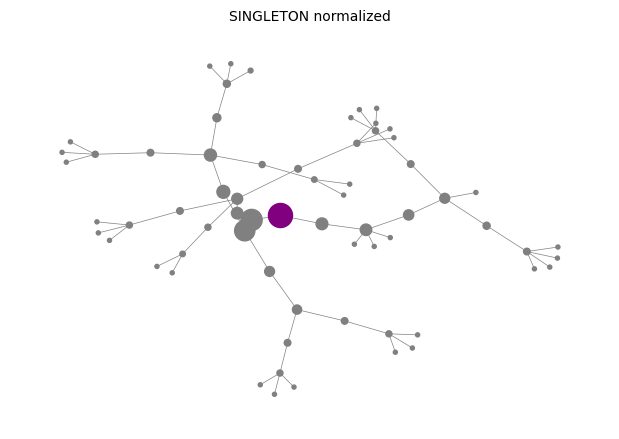

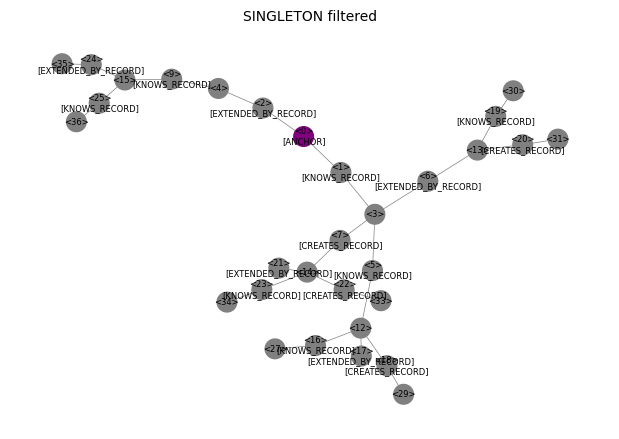

num nodes: 84
num nodes norm: 66
max presence: 84
min presence: 1
mean presence: 7.5606060606060606
median presence: 2.5
q[0.61] presence: 4.0


In [297]:
def filter_by_node_presence( G: nx.Graph, q=0.8 ):
    node_presence = [ data[ "presence" ] for n, data in normalized.nodes( data=True ) ]
    presence_thresh = np.quantile( node_presence, q )
    n_keep = [ n for n, data in normalized.nodes( data=True ) if data[ "presence" ] >= presence_thresh ]
    return G.subgraph( n_keep )


connected_pattern_graphs = { }
norm_pattern_graphs = { }
for pattern_type in tqdm( [ dp.value for dp in cpg_const.DesignPatternType ] ):
    patterns = pattern_graphs[ pattern_type ]
    patterns = [ normalize_graph( dp, max_distance=8 )[ 0 ] for dp in patterns ]  # TODO maybe this is not good ?
    connected = connect_graphs_at_anchor( patterns, keep_radius=10 )
    connected_pattern_graphs[ pattern_type ] = [ connected ]
    normalized, _ = normalize_graph( connected, max_distance=8 )
    norm_pattern_graphs[ pattern_type ] = [ normalized ]

for pattern_type in norm_pattern_graphs.keys():
    connected = connected_pattern_graphs[ pattern_type ][ 0 ]
    normalized = norm_pattern_graphs[ pattern_type ][ 0 ]
    node_presence = [ data[ "presence" ] for n, data in normalized.nodes( data=True ) ]
    node_sizes = misc_utils.map_num_array_to_range( node_presence, r_min=5, r_max=300 )
    plot_utils.plot_graph( normalized, title=f"{pattern_type} normalized",
                           nodeLabels=graph_utils.get_node_labels( normalized ),
                           nodeColors=graph_utils.get_node_colors( normalized ),
                           with_label=False, node_sizes=node_sizes )

    #q = 0.9 if np.max( node_presence ) > 60 else 0.7
    q = round( 1 - (normalized.number_of_nodes() / (connected.number_of_nodes() * 2)), 2 )
    filtered = filter_by_node_presence( normalized, q=q )
    norm_pattern_graphs[ pattern_type ] = [ filtered ]
    plot_utils.plot_graph( filtered, title=f"{pattern_type} filtered",
                           nodeLabels=graph_utils.get_node_labels( filtered ),
                           nodeColors=graph_utils.get_node_colors( filtered ) )

    print( "num nodes:", connected.number_of_nodes() )
    print( "num nodes norm:", normalized.number_of_nodes() )
    print( "max presence:", np.max( node_presence ) )
    print( "min presence:", np.min( node_presence ) )
    print( "mean presence:", np.mean( node_presence ) )
    print( "median presence:", np.median( node_presence ) )
    print( f"q[{q}] presence:", np.quantile( node_presence, q ) )

In [298]:
def compute_connected_subgraphs( G, a, n_min=-1, n_max=-1, total_max=-1 ):
    bfs_nodes = list( nx.bfs_tree( G, source=a ).nodes )
    subgraphs = [ ]
    if n_max < 0:
        n_max = len( bfs_nodes )
    for size in range( max( n_min, 1 ), n_max + 1 ):
        for subset in combinations( bfs_nodes, size ):
            subgraph = G.subgraph( subset )
            if nx.is_connected( subgraph ) and a in subgraph.nodes:
                subgraphs.append( subgraph.copy() )
                if total_max > 0 and len( subgraphs ) >= total_max:
                    return subgraphs

    return subgraphs


def calculate_weighted_score( predictions, conf ):
    # Split predictions into positive and negative counts
    pos_preds = [ p for p in predictions if p > conf ]
    neg_preds = [ p for p in predictions if p <= conf ]

    pos_count = len( pos_preds )
    neg_count = len( neg_preds )
    total_count = pos_count + neg_count

    if total_count == 0:
        return 0.0

    # Calculate the ratio of positive predictions
    pos_ratio = pos_count / total_count

    # Weight positive predictions higher if there are more positives
    pos_weight = pos_ratio
    neg_weight = 1 - pos_weight

    # Calculate the weighted average
    weighted_score = (pos_weight * sum( pos_preds ) / max( pos_count, 1 ) +
                      neg_weight * sum( neg_preds ) / max( neg_count, 1 )) / total_count

    return min( max( weighted_score, 0 ), 1 )


def has_pattern( model, graph, pattern_graphs, pattern_type,
                 conf=0.5, max_samples=20, bulk_size=128, subgraph_relation=3,
                 query_graph=False, plot=False, shuffle=True, seed=42, quantile=0.8 ):
    misc_utils.set_seed( seed )

    preds = [ ]
    pattern_type_queries = pattern_graphs[ pattern_type ]

    """
    connected_query = connect_graphs_at_anchor( pattern_type_queries[ :max_samples ], keep_radius=3 )
    preds.append( predict( model, graph, connected_query ) )
    """

    sources = [ ]
    queries = [ ]
    for query in pattern_type_queries[ :max_samples ]:
        target_source = query if query_graph else graph
        target_query = graph if query_graph else query
        max_subgraph_size = target_source.number_of_nodes() // subgraph_relation
        target_query = subgraph_from_anchor_of_size( target_query, max_subgraph_size )

        target_source, source_d = normalize_graph( target_source, max_distance=6 )
        if source_d < 3:
            continue

        """
        target_query, query_d = normalize_graph( target_query, max_distance=source_d - 1 )
        sub_queries = compute_connected_subgraphs( target_query, graph_utils.get_anchor( target_query ),
                                                   n_min=8, n_max=max_subgraph_size, total_max=bulk_size )
        sub_queries = sub_queries[ :bulk_size ]
        for sub_query in sub_queries:
            queries.append( sub_query )
            sources.append( target_source )
        """

        target_query, query_d = normalize_graph( target_query, max_distance=source_d - 1 )
        sub_queries = gen_normalized_path_combinations( target_query, max_d=source_d - 1 )
        if shuffle:
            rnd.shuffle( sub_queries )
        sub_queries = sub_queries[ :bulk_size ]
        for sub_query in sub_queries:
            queries.append( sub_query )
            sources.append( target_source )

        """
        for i in list( range( 1, 4 ) ):
            if source_d - i < 2:
                continue
            target_query, query_d = normalize_graph( target_query, max_distance=source_d - i )
            queries.append( target_query )
            sources.append( target_source )
        """

    def calculate_top_score_mean( preds, conf=0.5, top_k=3 ):
        preds = [ p > conf for p in preds ]
        if len( preds ) == 0:
            return 0.0
        return np.mean( sorted( preds, reverse=True )[ :top_k ] )

    query_preds, _ = model.predict_batch( sources, queries, bulk_size=bulk_size )
    if len( query_preds ) == 0:
        preds.append( 0.0 )
    else:
        #preds.append( calculate_weighted_score( query_preds, conf ) )
        #preds.append( calculate_top_score_mean( query_preds, conf=conf, top_k=3 ) )
        preds.append( np.quantile( query_preds, quantile ) )

        if plot:
            for idx, (s, q) in enumerate( zip( sources, queries ) ):
                combined, node_colors, edge_colors = combine_normalized(
                    s, q, matching_colors=matching_colors )
                plot_utils.plot_graph( combined,
                                       title=f"{pattern_type} query #{idx} ({float( query_preds[ idx ] ):.4})",
                                       nodeLabels=graph_utils.get_node_labels( combined ),
                                       nodeColors=node_colors, edgeColors=edge_colors )

    """
    for query in pattern_type_queries[ :max_samples ]:

        target_graph = query if query_graph else graph
        target_query = graph if query_graph else query
        max_subgraph_size = target_graph.number_of_nodes() // subgraph_relation
        queries = compute_connected_subgraphs( target_query, graph_utils.get_anchor( target_query ),
                                               n_min=2, n_max=max_subgraph_size, total_max=bulk_size )
        queries = queries[ :bulk_size ]
        sources = [ target_graph for _ in list( range( len( queries ) ) ) ]

        if len( queries ) == 0:
            continue

        query_preds = predict_bulk( model, sources, queries )
        query_preds = np.array( sorted( query_preds ) )

        # simple voting
        query_preds_pos = sum( p > conf for p in query_preds )
        query_preds_neg = sum( p <= conf for p in query_preds )
        query_pred = 1.0 if query_preds_pos > query_preds_neg else 0.0
        preds.append( query_pred )

        # calc inter-quantile range measurement
        #q = 0.1
        #query_q = np.quantile( query_preds, 1-q ) - np.quantile( query_preds, q )
        #preds.append( query_q )

        #query_mean = np.mean( query_preds )
        #preds.append( query_mean )
    """
    preds = np.array( preds )
    mean = np.mean( preds )
    """
    median = np.median( preds )
    var = np.var( preds )
    std = np.std( preds )
    maxp = np.max( preds )
    print(
        f"Total predictions is {mean > conf}: mean[{mean:.3}] median[{median:.3}] var[{var:.3}] std[{std:.3}] max[{maxp:.3}]" )
    """
    return mean

In [299]:
NO_PATTERN = "N/D"


def get_valid_patterns( pattern_graphs ):
    return [ pattern for pattern in pattern_graphs.keys() if pattern != NO_PATTERN ]

  0%|          | 0/7 [00:00<?, ?it/s]

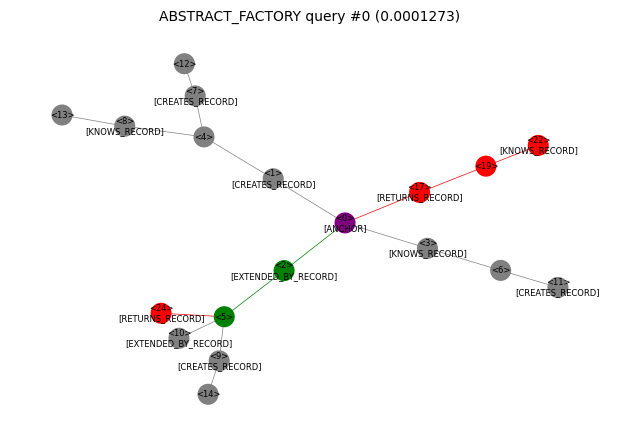

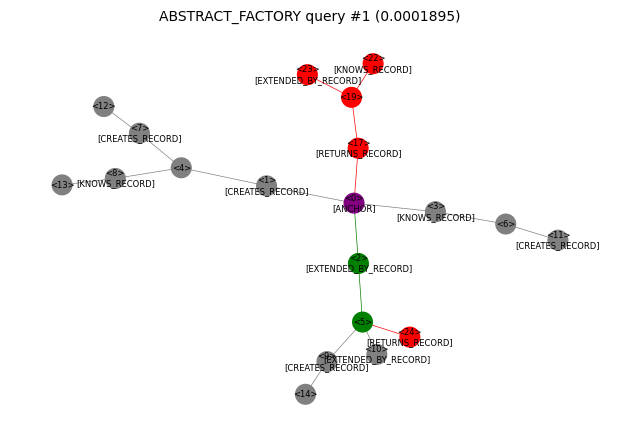

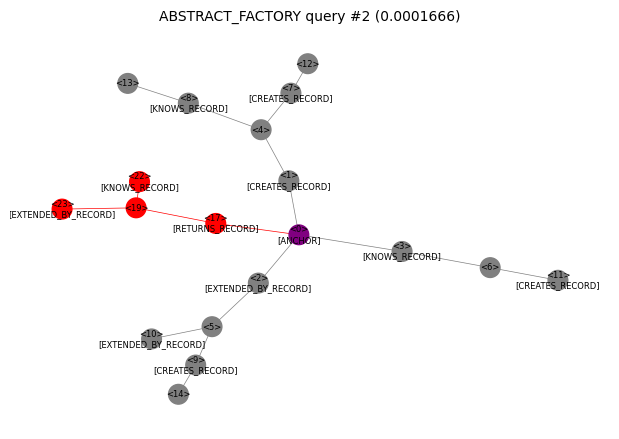

 14%|█▍        | 1/7 [00:00<00:01,  3.29it/s]

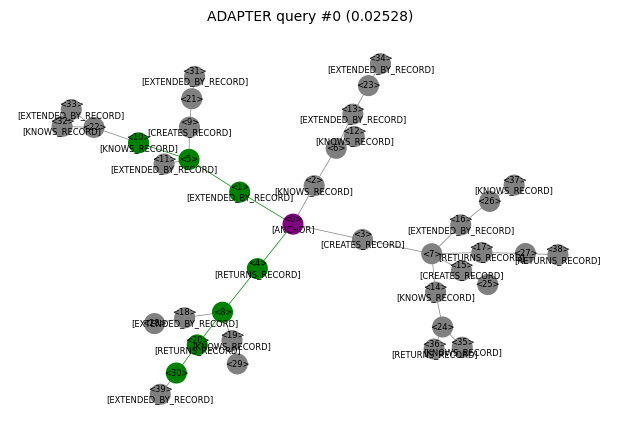

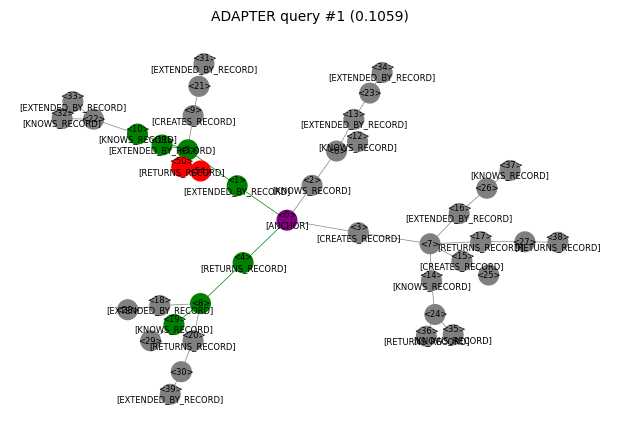

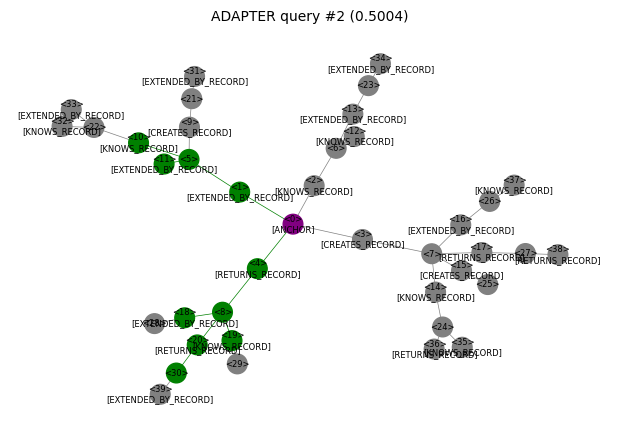

 29%|██▊       | 2/7 [00:00<00:01,  3.07it/s]

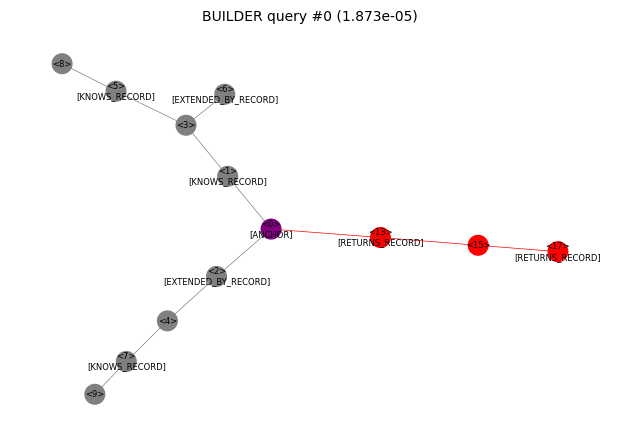

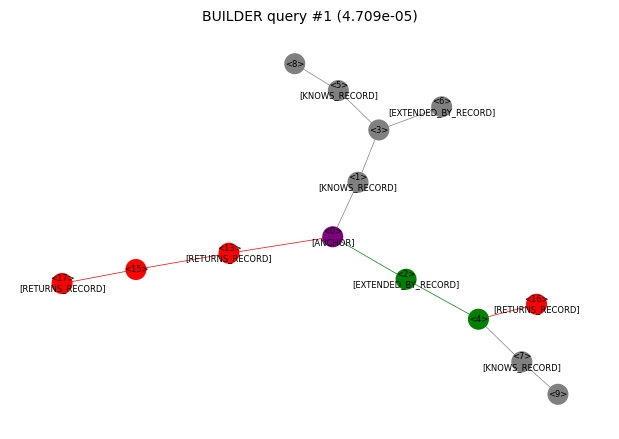

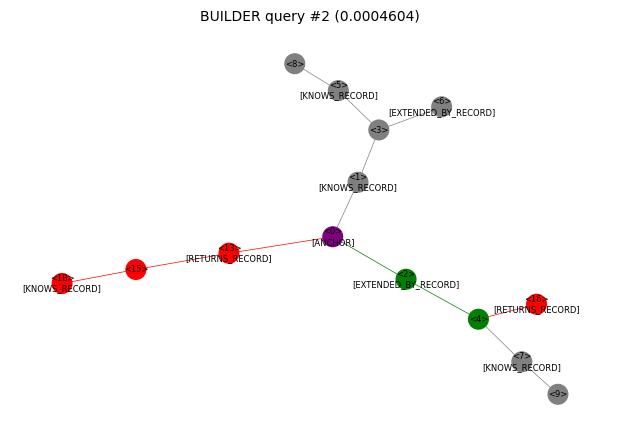

 43%|████▎     | 3/7 [00:00<00:01,  3.26it/s]

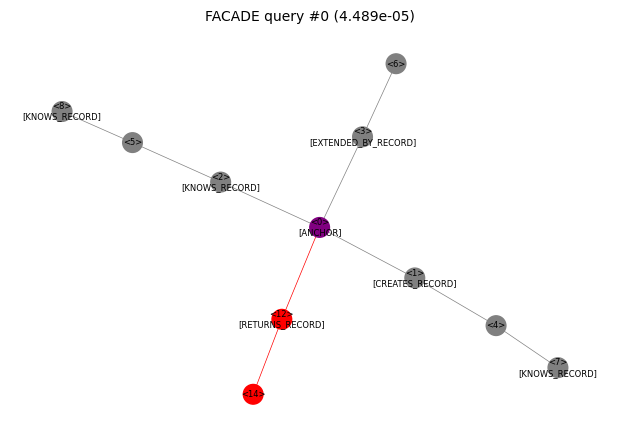

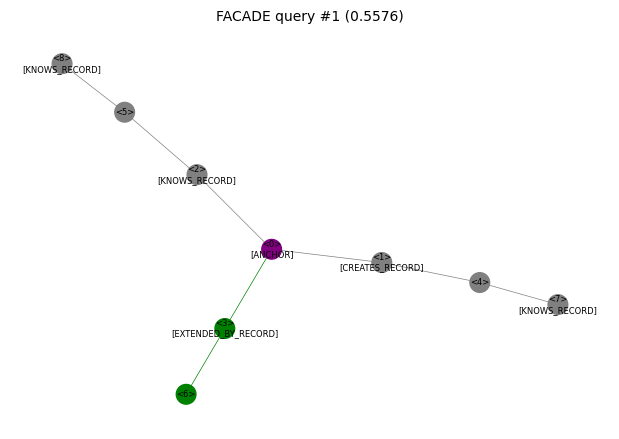

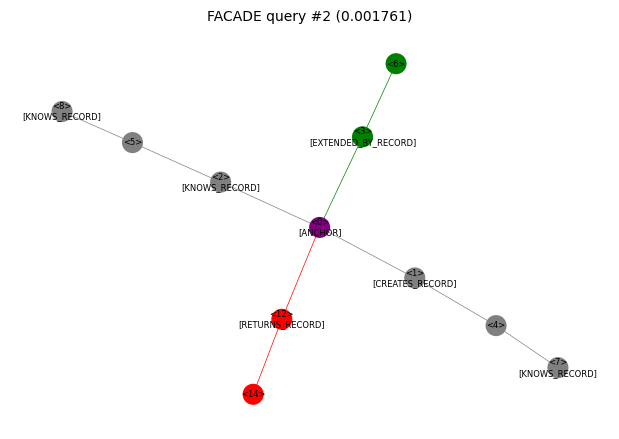

 57%|█████▋    | 4/7 [00:01<00:00,  3.41it/s]

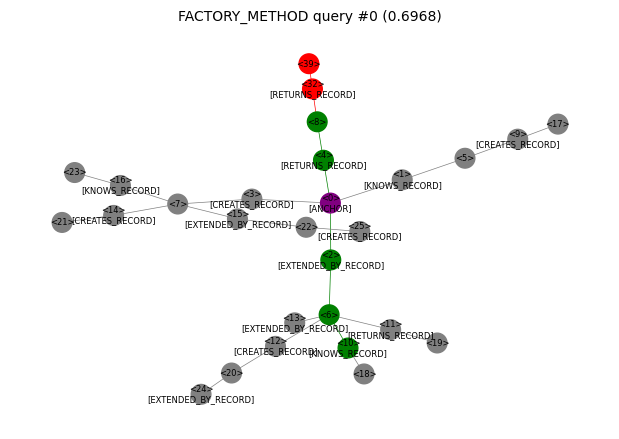

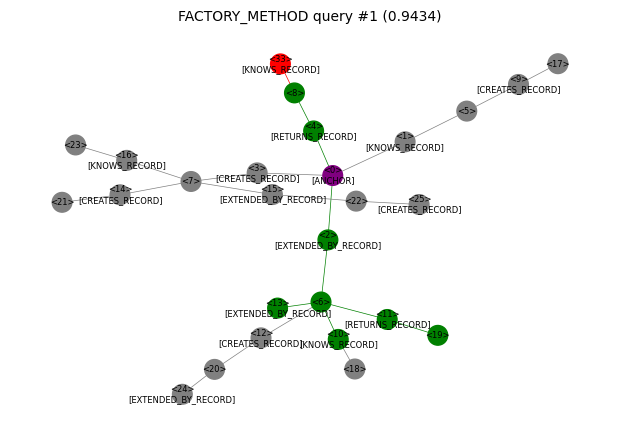

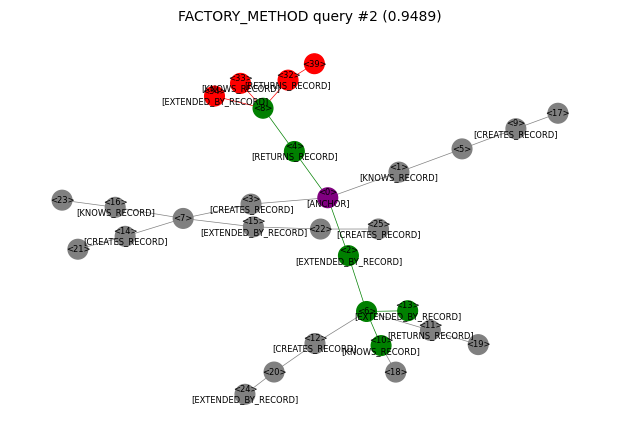

 71%|███████▏  | 5/7 [00:01<00:00,  3.26it/s]

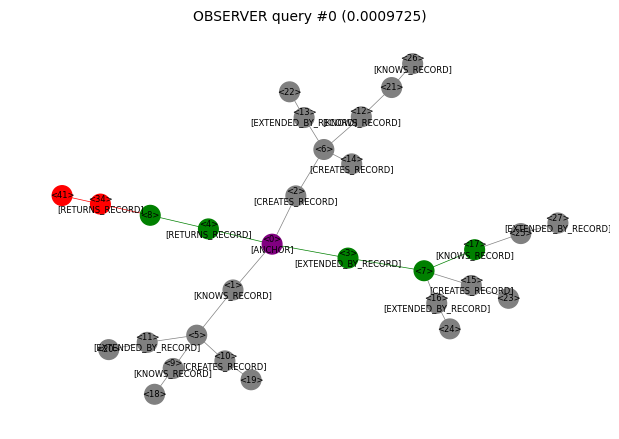

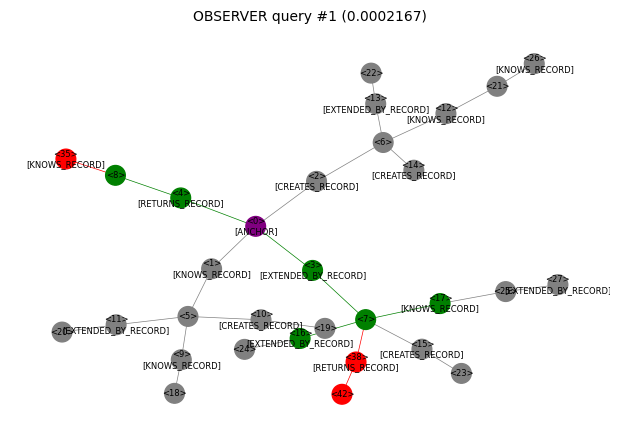

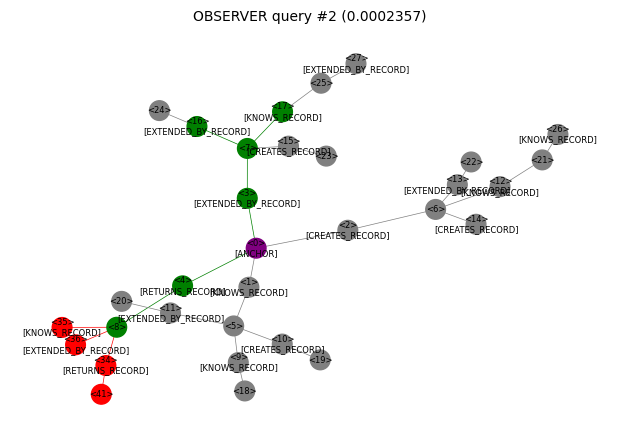

 86%|████████▌ | 6/7 [00:01<00:00,  3.14it/s]

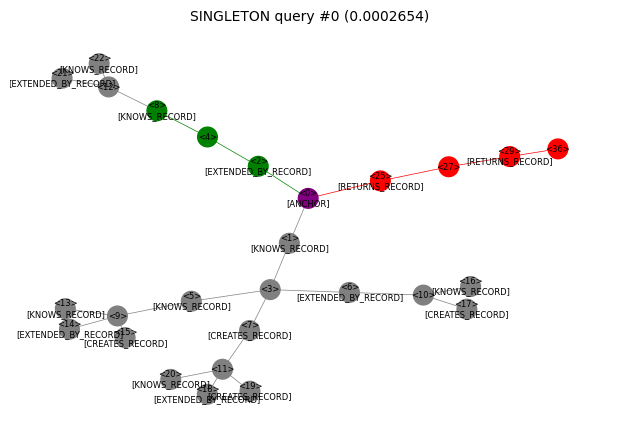

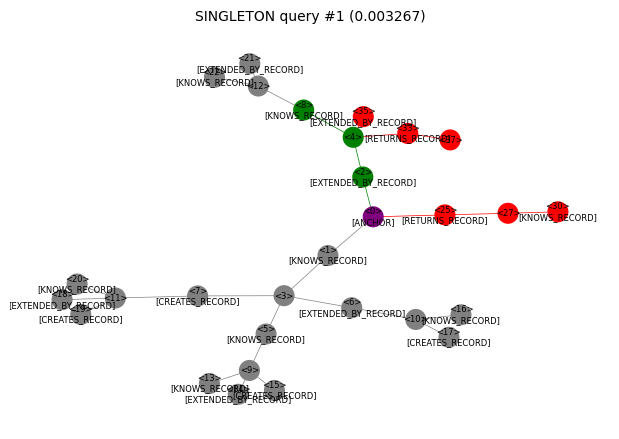

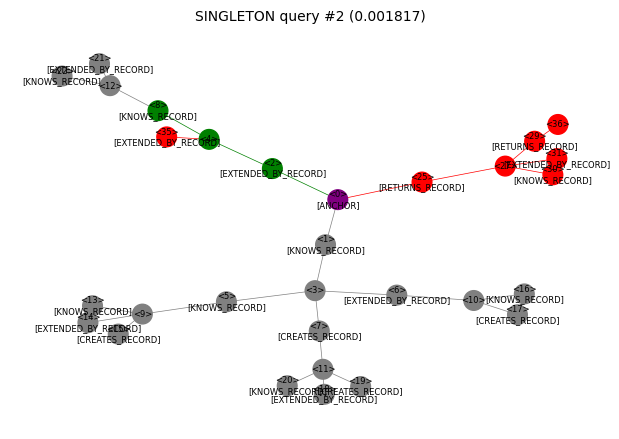

100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


{'ABSTRACT_FACTORY': 0.00018,
 'BUILDER': 0.00038,
 'OBSERVER': 0.00083,
 'SINGLETON': 0.00298,
 'ADAPTER': 0.42148,
 'FACADE': 0.44643,
 'FACTORY_METHOD': 0.94778}

In [300]:
source_graph = pattern_graphs[ cpg_const.DesignPatternType.FACTORY_METHOD.value ][ 2 ]
#source_graph = pattern_graphs[ NO_PATTERN ][ 2 ]
predictions = { }
"""
for pattern in tqdm( get_valid_patterns( pattern_graphs ) ):
    pred = has_pattern( model, source_graph, pattern_graphs, pattern, query_graph=True, subgraph_relation=2 )
    predictions[ pattern ] = pred
"""
for pattern_type in tqdm( get_valid_patterns( norm_pattern_graphs ) ):
    pred = has_pattern( model, source_graph, norm_pattern_graphs, pattern_type,
                        subgraph_relation=1, conf=0.99, bulk_size=3, quantile=0.9,
                        query_graph=True, plot=True, shuffle=True )
    predictions[ pattern_type ] = pred

predictions = { k: round( float( v ), 5 ) for k, v in sorted( predictions.items(), key=lambda item: item[ 1 ] ) }
predictions

In [301]:
true_labels = [ ]
pred_labels = [ ]
preds = [ ]
conf = 0.2
samples_per_pattern = 10
for source_pattern_type in pattern_graphs.keys():
    print( f"Calc examples for pattern {source_pattern_type}" )
    for source_pattern in tqdm( pattern_graphs[ source_pattern_type ][ :samples_per_pattern ] ):
        best_pred = 0.0
        pattern_type_pred = NO_PATTERN
        for query_pattern_type in get_valid_patterns( norm_pattern_graphs ):
            pred = has_pattern( model, source_pattern,
                                norm_pattern_graphs, query_pattern_type,
                                conf=conf, max_samples=10, bulk_size=128, subgraph_relation=1,
                                query_graph=True, shuffle=True )
            if pred > best_pred and pred > conf:
                best_pred = pred
                pattern_type_pred = query_pattern_type
        true_labels.append( source_pattern_type )
        pred_labels.append( pattern_type_pred )
        preds.append( best_pred )

Calc examples for pattern OBSERVER


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Calc examples for pattern FACTORY_METHOD


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Calc examples for pattern BUILDER


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Calc examples for pattern ADAPTER


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Calc examples for pattern SINGLETON


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Calc examples for pattern FACADE


100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Calc examples for pattern ABSTRACT_FACTORY


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Calc examples for pattern N/D


100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'OBSERVER'),
  Text(0, 1, 'FACTORY_METHOD'),
  Text(0, 2, 'BUILDER'),
  Text(0, 3, 'ADAPTER'),
  Text(0, 4, 'SINGLETON'),
  Text(0, 5, 'FACADE'),
  Text(0, 6, 'ABSTRACT_FACTORY'),
  Text(0, 7, 'N/D')])

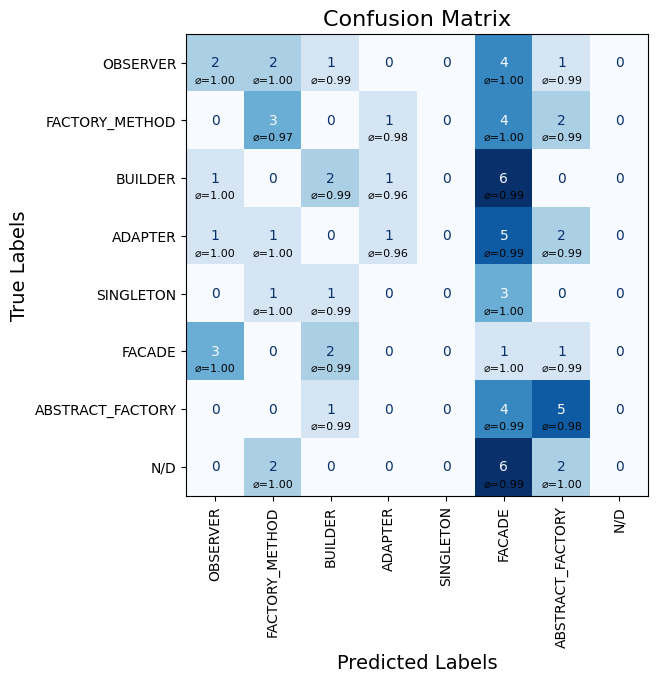

In [302]:
labels = [ *pattern_graphs.keys() ]
cm = confusion_matrix( true_labels, pred_labels, labels=labels )

confidence_matrix = np.zeros_like( cm, dtype=float )
count_matrix = np.zeros_like( cm, dtype=int )
preds = [ float( p ) for p in preds ]
for true, pred, conf in zip( true_labels, pred_labels, preds ):
    i = labels.index( true )
    j = labels.index( pred )
    confidence_matrix[ i, j ] += conf
    count_matrix[ i, j ] += 1
average_confidence = np.divide( confidence_matrix, count_matrix,
                                out=np.zeros_like( confidence_matrix ),
                                where=count_matrix != 0 )

fig, ax = plt.subplots( figsize=(6, 6) )
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=labels )
disp.plot( cmap=plt.cm.Blues, ax=ax, colorbar=False )

for i in range(len(labels)):
    for j in range(len(labels)):
        if cm[i, j] > 0: 
            ax.text(j, i + 0.3, f"⌀={average_confidence[i, j]:.2f}", 
                    ha='center', va='center', 
                    color='black', fontsize=8)
            

plt.title( "Confusion Matrix", fontsize=16 )
plt.xlabel( "Predicted Labels", fontsize=14 )
plt.ylabel( "True Labels", fontsize=14 )
plt.xticks( fontsize=10, rotation=90 )
plt.yticks( fontsize=10 )

In [303]:
def enum_to_numeric( value ):
    if value == NO_PATTERN:
        return 0
    enum = misc_utils.get_enum_by_value( cpg_const.DesignPatternType, value )
    return misc_utils.get_enum_idx( enum )


x_labels = [ enum_to_numeric( v ) for v in pred_labels ]
y_labels = [ enum_to_numeric( v ) for v in true_labels ]
cm_acc = accuracy_score( y_labels, x_labels )
cm_pre = precision_score( y_labels, x_labels, average="weighted", zero_division=np.nan )
cm_rec = recall_score( y_labels, x_labels, average="weighted", zero_division=np.nan )
cm_f1s = f1_score( y_labels, x_labels, average="weighted", zero_division=np.nan )

classes = sorted( set( y_labels ) )
y_binarized = label_binarize( y_labels, classes=classes )
x_binarized = label_binarize( x_labels, classes=classes )
cm_roc = roc_auc_score( y_binarized, x_binarized, average="weighted", multi_class="ovr" )
cm_prc = average_precision_score( y_binarized, x_binarized, average="weighted" )

print( f"Roc=[{cm_roc:.3}] Acc=[{cm_acc:.3}]"
       f" Prec=[{cm_pre:.3}] Rec=[{cm_rec:.3}] F1=[{cm_f1s:.3}]"
       f" AvgPrec=[{cm_prc:.3}]" )

Roc=[0.544] Acc=[0.194] Prec=[0.288] Rec=[0.194] F1=[0.196] AvgPrec=[0.165]
